### Sweep pitch up and down, sonograpms and hidden unit visualization

In [24]:
# Set parameter file and model to load
from utils.myUtils import mostRecent 

# chose an existing pickledParamFile and run loadModelForEvaluation
pickledParamFile = mostRecent("../RNNControl/model/*modelParams.pkl")
#pickledParamFile = mostRecent("/home/lonce/ZCODE/PYTORCH/RNNControl/model/*modelParams.pkl")
#pickledParamFile = '/home/lonce/ZCODE/PYTORCH/HUZ/RNNControl/model.WorkingTransients/modelParams.pkl'

# choose saved model to run (defaults to the last saved if loadmodelfile is undefined or None)
# Note: looks in same directory as pickledParamFile
loadModelFileName=None
#loadModelFileName='2018-11-23_09-37-53_model_epoch1_step90.pth'
#loadModelFileName='2018-10-31_16-47-25_model_epoch1_step4000.pth'

In [25]:
# run notebook to load analysis/synthesis code
%run loadModelForEvaluation.ipynb

if 'sample_rate' not in params :   #older versions didn't save sample_rate
    params['sample_rate']=16000

python version 3.6.6
torch version 0.4.1
will read params from ../RNNControl/model/2019-06-24_18-13-17_modelParams.pkl
modelDir is ../RNNControl/model

 Saved Parameters:

{'batch_size': 256,
 'datadir': '/home/lonce/ZCODE/PYTORCH/data/faustData/dataset',
 'hiNote': 75,
 'hiddenSize': 40,
 'lowNote': 63,
 'lr': 0.005,
 'max_steps': 18000,
 'nLayers': 4,
 'noise': 0,
 'num_epochs': 1,
 'paramdir': '/home/lonce/ZCODE/PYTORCH/data/faustData/dataparams',
 'props': ['instID', 'pressure', 'midiPitch', 'tongue'],
 'runTimeStamp': '2019-06-24_18-13-17',
 'sample_rate': 16000,
 'savedModel': '2019-06-24_18-13-17_model_epoch1_step18000.pth',
 'savedSteps': 18000,
 'savemodel': True,
 'savemodel_interval': 500,
 'savemodeldir': '/home/lonce/ZCODE/PYTORCH/RNNControl/model',
 'seqLen': 256,
 'stride': 1}
setting loadModelFile to ../RNNControl/model/2019-06-24_18-13-17_model_epoch1_step18000.pth
**************************************************************************************************.
Will 

### Primer

In [26]:
# Make noisy nuetral Priming signal 
myp=np.zeros([1,seqLen,len(params['props'])+1])
# !! PRIMING DOES MATTER - has to be a certain level of noise
myp[0,:,0]=.3*np.random.ranf([seqLen])-.15 #signal
myp[0,:,1]= .45+.1*np.random.ranf([seqLen])     #instrument
myp[0,:,2]= .5*np.random.ranf([seqLen])    #pressure1
#myp[0,:,3]=1-myp[0,:,2]    #pressure2
myp[0,:,3]= np.random.ranf([seqLen])    #pitch
myp[0,:,4]= np.random.ranf([seqLen])    #tongue
myprimer=torch.tensor(myp, dtype=torch.float)

### <font color="brown"> Generate pitch sweep signals, show spectrograms</font>

/home/lonce/anaconda3/envs/snn/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


output file name is ./output/pitchsweep_i0.0
output file name is ./output/pitchsweep_i0.5


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fadde213be0>>
Traceback (most recent call last):
  File "/home/lonce/anaconda3/envs/snn/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/lonce/anaconda3/envs/snn/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/lonce/anaconda3/envs/snn/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/lonce/anaconda3/envs/snn/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/lonce/anaconda3/envs/snn/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/lonce/anaconda3/envs/snn/lib/python3.

output file name is ./output/pitchsweep_i1.0


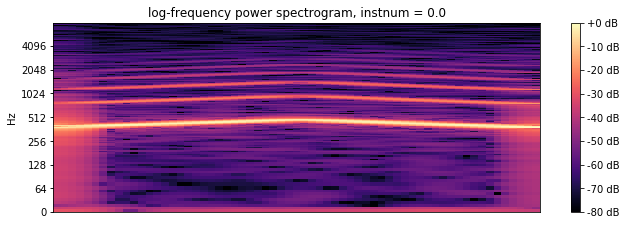

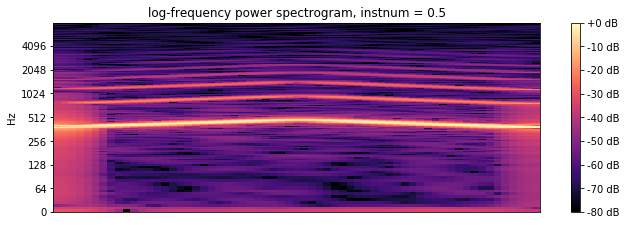

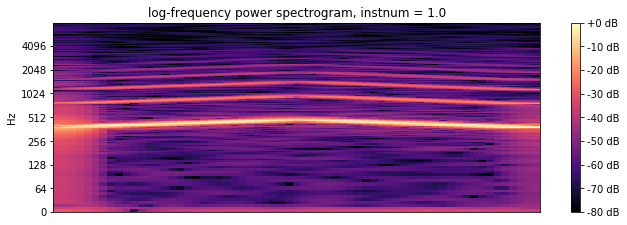

In [27]:
import librosa.display
genlen= int(.5*params['sample_rate'])

instrument_list=[0.0, .5, 1.0]

def fsweep(snum) : 
    global instnum
    t=snum/genlen #snum/params['sample_rate']
    #p=2*(.5-np.abs(.5-t))
    p=.25+(.5-np.abs(.5-t))
    v=.6
    i=instnum
    b=1 #"blowing" (tongue in the param file)
    return [i,v,p,b]   

y = [None]*len(instrument_list)
hdn=[None]*len(instrument_list)

for count in range(len(instrument_list)) : 
    instnum=instrument_list[count]

    
    
    #result=evaluate(genlen, fsweep, chooseTemperature, primeWith=k_primeSignal) #choose a middle value of the param for evaluation
    #y=result[k_primeLen:, 0]
    
    #y=generate(rnn, genlen, primer=myprimer, paramvect=fsweep)[seqLen:]
    
    y[count], hdn[count]=generate(rnn, genlen, primer=myprimer, paramvect=fsweep, returnHiddenSequence=True)

    #remove primer
    y[count]=y[count][seqLen:]
    hdn[count]=hdn[count][seqLen:]


    sr=params['sample_rate']
    plt.figure(figsize=(24, 16))
    D = librosa.amplitude_to_db(librosa.stft(y[count], hop_length=128), ref=np.max)
    plt.subplot(4, 2, count+1)
    librosa.display.specshow(D, y_axis='log', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title('log-frequency power spectrogram, instnum = ' +str(instnum))


    #save wave file
    #if (instnum) == 0 or (instnum == 1) :
    #    outfilename=k_rootoutname + "pitchsweep_i" +str(int(instnum))+ instrument[int(instnum)].name 
    #else : 
    outfilename=k_rootoutname + "/pitchsweep_i" +str(instnum) 

    print("output file name is " + outfilename)
    librosa.output.write_wav(outfilename + ".wav", y[count], params['sample_rate'])
    
    #outfilename=k_outpath+"/subfig" + str(saveidx)+".png"
    #print("saving to file " + outfilename)
    #extent = a[saveidx].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    #print(extent)
    #fig.savefig(outfilename +".png", bbox_inches=extent.padded(.4))
    plt.savefig(outfilename +".png")


In [34]:
# Sonify a signal 

from IPython.display import Audio, display
# Listen to a sweeps (set instnum and run cell)
#instnum=0.5
instnum=0.5   #must be from instrument_list[] above

outfilename=k_rootoutname + "/pitchsweep_i" +str(instnum) + ".wav"

print("file name is " + outfilename)
y,sr=librosa.core.load(outfilename, sr=None) 
display(Audio(y, rate=sr, autoplay=True))

file name is ./output/pitchsweep_i0.5.wav


### <font color="brown"> Show Hidden Units over time</font>

In [29]:
# Activation over time for signal from call to generate()

import matplotlib as mpl
from ipywidgets import interact,interactive
from ipywidgets import FloatSlider, IntSlider
from IPython.display import Audio

instIndex=1  #indexes instrument_list[] above

#Separate layers for visualization 
#want each layers[n] to be 40 rows of length timesteps=400 (40 x 400)
layers = [np.transpose([x[n] for x in hdn[instIndex]]) for n in range(0,params['nLayers']) ]

t=list(range(0,len(hdn[instIndex])))
elmts=[list(range(0,len(layers[n][0]))) for n in range(0,params['nLayers'])]

print("Layer[0] has {} rows of length {}".format(len(layers[0]), len(layers[0][0])))

#*************************

def widgetfunc(layer,snum,scale):

    global t
    global layers
    
    print("length of time array = {}".format(len(t)))
    
    endSnum=int(min(snum+40*math.pow(2,scale) , len(t)-1))
    print("endSnum is {}".format(endSnum))
    
    numxticks=10
    xtick_spacing=max(int((endSnum-snum)/numxticks), 1)
    xlabels=range(snum, endSnum, xtick_spacing)
    
    aspectRatio=(endSnum-snum)/40

    
    numplots=40
    f, axarr = plt.subplots(numplots, sharex=True, sharey=True, figsize=(30,30))
    for i in range(numplots) :
        axarr[i].plot(t[snum:endSnum], layers[layer][i,snum:endSnum])
        axarr.flat[i].set(xlabel='samples', ylabel=i)
        axarr[i].set_yticks([])

    
    axarr[0].set_title('Activations for layer {}'.format(layer))

    # Fine-tune figure; make subplots close to each other and hide x ticks for
    # all but bottom plot.
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    

    
layerSlider=IntSlider(min=0, max=params['nLayers']-1, step=1, value=0, continuous_update=False, description='layer')
snumSlider=IntSlider(min=0, max=len(t), step=1, value=0,  continuous_update=False, description='sampleNumber')
scaleSlider=FloatSlider(min=0, max=12, step=.1, value=12,  continuous_update=False, description='scale')

w = interactive(widgetfunc, layer=layerSlider,snum=snumSlider, scale=scaleSlider)
display(w)

Layer[0] has 40 rows of length 7745


interactive(children=(IntSlider(value=0, continuous_update=False, description='layer', max=3), IntSlider(value…

### Sonify individual hidden unit activations 

In [30]:
# Sonify activation of individual cells over time for signal from instnum visualized above

def widgetfunc(layer,unit,snum,scale):
    """
    @param layer - hidden layer number
    #unit to listen to
    snum - the sample number to start playing from 
    scale - (units of octaves) determines what sample number to play until (bigger numbers play for longer)
    """
    global t
    global layers
    
    endSnum=int(min(snum+40*math.pow(2,scale) , len(t)-1))

    display(Audio(layers[layer][unit,snum:endSnum], rate=sr, autoplay=True))
    
layerSlider=IntSlider(min=0, max=params['nLayers']-1, step=1, value=0, continuous_update=False, description='layer')
unitSlider=IntSlider(min=0, max=40, step=1, value=0, continuous_update=False, description='unit')
snumSlider=IntSlider(min=0, max=len(t), step=1, value=0,  continuous_update=False, description='sampleNumber')
scaleSlider=FloatSlider(min=0, max=12, step=.1, value=12,  continuous_update=False, description='scale')

w = interactive(widgetfunc, layer=layerSlider, unit=unitSlider, snum=snumSlider, scale=scaleSlider)
display(w)

interactive(children=(IntSlider(value=0, continuous_update=False, description='layer', max=3), IntSlider(value…